# Project: Vehicle Detection and Tracking

Import Modules
---

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from skimage.feature import hog
from sklearn.ensemble import BaggingClassifier
from time import time
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label
%matplotlib inline

Dataset read and visualization
---

Dataset Loaded
Total car images:  8792
Total non-car images:  8968
Shape of each image:  (64, 64, 3)
Time taken to load the dataset: 96.731s


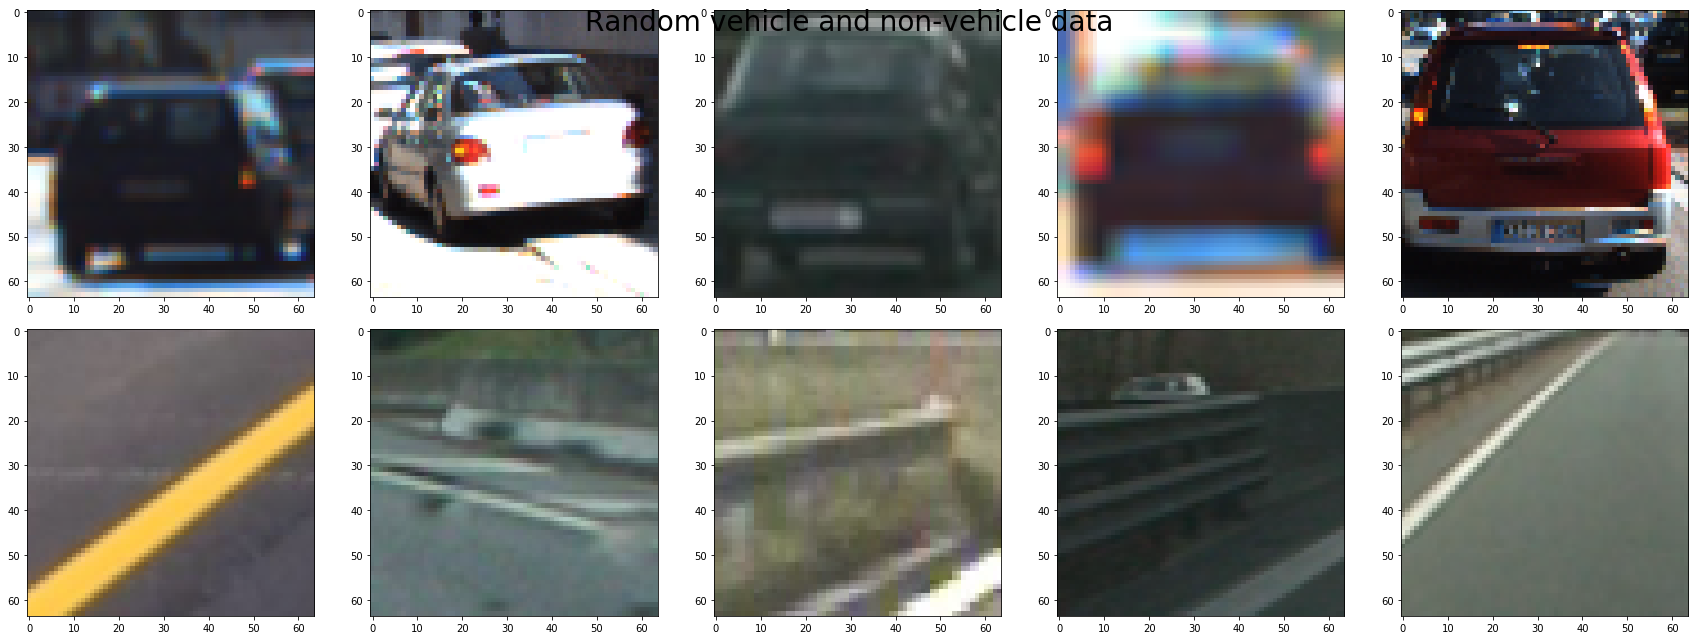

In [2]:
t0 = time()
vehicles = []
non_vehicles = []

vehicle_names = glob.glob('vehicles/GTI_Far/image*.png') + \
    glob.glob('vehicles/GTI_Left/image*.png') + \
    glob.glob('vehicles/GTI_MiddleClose/image*.png') + \
    glob.glob('vehicles/GTI_Right/image*.png') + \
    glob.glob('vehicles/KITTI_extracted/*.png')
    
for v in vehicle_names:
    vehicles.append(cv2.cvtColor(cv2.imread(v), cv2.COLOR_BGR2RGB))
    
vehicles = np.array(vehicles, dtype=np.uint8)

non_vehicle_names = glob.glob('non-vehicles/GTI/image*.png') + \
                    glob.glob('non-vehicles/Extras/extra*.png')
    
for nv in non_vehicle_names:
    non_vehicles.append(cv2.cvtColor(cv2.imread(nv), cv2.COLOR_BGR2RGB))

non_vehicles = np.array(non_vehicles, dtype=np.uint8)
print ('Dataset Loaded')
print ('Total car images: ', vehicles.shape[0])
print ('Total non-car images: ', non_vehicles.shape[0])
print ('Shape of each image: ', vehicles.shape[1:])
print ('Time taken to load the dataset: {:.3f}s'.format(time()-t0))

# Display some random images
vehicle_image_index = np.random.randint(vehicles.shape[0], size=5)
non_vehicle_image_index = np.random.randint(non_vehicles.shape[0], size=5)
# plt.figure()
fig, ax = plt.subplots(2, 5, figsize=(24,9))
fig.suptitle('Random vehicle and non-vehicle data', size=28)
for count, t in enumerate(vehicle_image_index):
    ax[0][count].imshow(vehicles[t])
for count, t in enumerate(non_vehicle_image_index):
    ax[1][count].imshow(non_vehicles[t])
fig.subplots_adjust(top=0.9)
fig.savefig('output_images/dataset.jpg')
fig.tight_layout()
plt.show()

Helper functions
---

In [3]:
def bin_spatial(img, size=32, vis=False):
    '''
        Function to get features by resizing the image to given size
        img - Image to be resized
        size - Reduced size of the image
        returns feature vector of length (size*size*3)
    '''
    features = cv2.resize(img, (size, size))
    if vis == True:
        plt.imshow(features)
        plt.imsave('output_images/bin_spatial.jpg', features)
        plt.show()
    return features.ravel()


def color_hist(img, nbins=32, bins_range=(0,256), vis=False):
    '''
        Function to get features based on the histogram of the channels
        img - Image from which histogram features are extracted
        nbins - Number of bins in the histogram. By default 32
        bins_range - Range of the bins. Default is 0-255
        returns feature vector of length (3*nBins)
    '''
    ch1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    if vis == True:
        bin_edges = ch1_hist[1]
        bincen = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
        fig = plt.figure()
        plt.bar(bincen, ch1_hist[0])
        plt.xlim(0, 256)
        plt.title('Y Histogram')
        fig.savefig('output_images/color_hist.jpg')
        plt.tight_layout()
        plt.show()
        fig.clf()
    features = ch1_hist[0]
    return features


def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    '''
        Function to obtain the hog features
        img - Image on which HOG features are obtained
        orient - number of orientation bins
        pix_per_cell - number of pixels in each cell
        cell_per_block - number of cells per block
        returns feature vector of length (ny_blocks*nx_blocks*cell_per_block*cell_per_block*orient)
    '''
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        plt.imshow(hog_image, cmap='gray')
        plt.imsave('output_images/hog_features.jpg', hog_image)
        plt.show()
        return features
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def slide_window(img_height, img_width, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img_width
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img_height
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def feature_extraction(img, orient, pix_per_cell, cell_per_block, visualize, spatial_size, bins, isSingleImage, windows):
    features = []
    if isSingleImage == True:
        assert (len(windows) > 1)
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        for win in windows:
            interest_image = feature_image[win[0][1]:win[1][1], win[0][0]:win[1][0]]
            interest_image = cv2.resize(interest_image, (64,64))
            spatial_features = bin_spatial(interest_image, spatial_size, vis=visualize)
            hist_features = color_hist(interest_image, nbins=bins, bins_range=(0,256), vis=visualize)
            hog_features = get_hog_features(interest_image[:,:,0], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=visualize, feature_vec=True)
            features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    else:
        for image in img:
            if visualize == True:
                plt.imshow(image)
                plt.imsave('output_images/original.jpg', image)
                plt.show()
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            if visualize == True:
                plt.imshow(feature_image)
                plt.imsave('output_images/converted.jpg', feature_image)
                plt.show()
            hog_features = get_hog_features(feature_image[:,:,0], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=visualize, feature_vec=True)
            spatial_features = bin_spatial(feature_image, size=spatial_size, vis=visualize)
            hist_features = color_hist(feature_image, nbins=bins, bins_range=(0,256), vis=visualize)
            features.append(np.concatenate((spatial_features, hist_features, hog_features)))

    return features

Feature extraction
---

In [4]:
orient = 9
pix_per_cell = 16
cell_per_block = 2
nbins = 32
spatial_size = 16

t0 = time()
vehicle_features = feature_extraction(vehicles, orient, pix_per_cell, cell_per_block, False, spatial_size, nbins, False, None)
non_vehicle_features = feature_extraction(non_vehicles, orient, pix_per_cell, cell_per_block, False, spatial_size, nbins, False, None)
print ('shape of vehicle features: ', len(vehicle_features), len(vehicle_features[0]))
print ('shape of non-vehicle features: ', len(non_vehicle_features), len(non_vehicle_features[0]))
X = np.vstack((vehicle_features, non_vehicle_features))
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))
print ('Feature extracted...')
print ('shape of the feature vector and label vector: ', X.shape, y.shape)
print ('Time taken to extract features: {:.3f}s'.format(time()-t0))
vehicle_features = None
non_vehicle_features = None

shape of vehicle features:  8792 1124
shape of non-vehicle features:  8968 1124
Feature extracted...
shape of the feature vector and label vector:  (17760, 1124) (17760,)
Time taken to extract features: 20.097s


Normalization
---

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)
print ('shape of the training set data: ', X_train.shape)
print('shape of the validation set data: ', X_val.shape)
scaler = StandardScaler()
scaler.fit(X_train)
scaled_x_train = scaler.transform(X_train)
scaled_x_valid = scaler.transform(X_val)
print ('Data is split into train and validation sets and is scaled')

shape of the training set data:  (14208, 1124)
shape of the validation set data:  (3552, 1124)
Data is split into train and validation sets and is scaled


Train classifier
---

In [6]:
start_time = time()
clf = SVC()
clf.fit(scaled_x_train, y_train)
pred = clf.predict(scaled_x_valid)
acc = accuracy_score(pred, y_val)
print ('validation accuracy: {:.3f}'.format(acc))
print ('Time elapsed for classification: {:.3f}s'.format(time()-start_time))
train_data = {'scaler': scaler, 'clf':clf}
joblib.dump(train_data, 'classifier.p')
clf = None
X = None
y = None
scaled_x_train = None
scaled_x_valid = None
X_train = None
X_val = None
y_train = None
y_val = None

validation accuracy: 0.994
Time elapsed for classification: 66.592s


Process test images and video frames
---

In [7]:
orient = 9
pix_per_cell = 16
cell_per_block = 2
nbins = 32
spatial_size = 16

# Generate sliding windows
image_height = 720
image_width = 1280
# Sliding window scale 1 - (64, 64) with 75% overlap area
wins1 = slide_window(image_height, image_width, x_start_stop=[None, None], y_start_stop=[360, 488], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
# Sliding window scale 2 - (96, 96) with 50% overlap area
wins2 = slide_window(image_height, image_width, x_start_stop=[None, None], y_start_stop=[424, 616], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
# Sliding window scale 3 - (128, 128) with 50% overlap area
wins3 = slide_window(image_height, image_width, x_start_stop=[None, None], y_start_stop=[520, 680], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
windows = np.vstack((wins1, wins2, wins3))

# Load classifier
train_data = joblib.load('classifier.p')
scaler = train_data['scaler']
clf = train_data['clf']

# Process image
def ProcessImage(img, visualize=False):
    if visualize == True:
        window_image = np.copy(img)
        for window in windows:
            cv2.rectangle(window_image, (window[0][0], window[0][1]), (window[1][0], window[1][1]), (255, 255, 0), 4)
        plt.imshow(window_image)
        plt.show()
    features = feature_extraction(img, orient, pix_per_cell, cell_per_block, False, spatial_size, nbins, True, windows)
    scaled_features = scaler.transform(features)
    pred = clf.predict(scaled_features)
    idx = np.where(pred == 1.)
    draw_img = np.copy(img)
    if (len(idx) > 0):
        identified_windows = windows[idx]
    if visualize == True:
        for id_win in identified_windows:
            cv2.rectangle(draw_img, (id_win[0][0], id_win[0][1]), (id_win[1][0], id_win[1][1]), (0, 0, 255), 6)
        plt.imshow(draw_img)
        plt.show()
    heatmap = np.zeros_like(img[:,:,0], np.float32)
    heat = add_heat(heatmap, identified_windows)
    if visualize == True:
        plt.imshow(heat)
        plt.show()
    heat = apply_threshold(heat, 2)
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

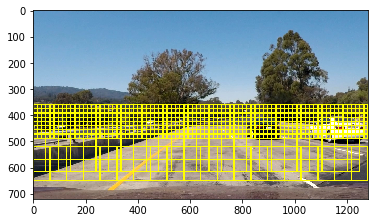

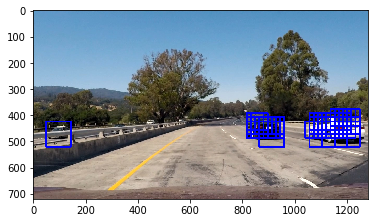

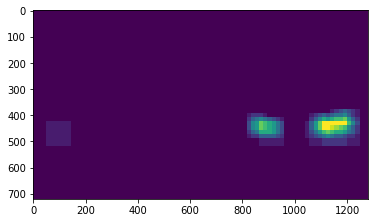

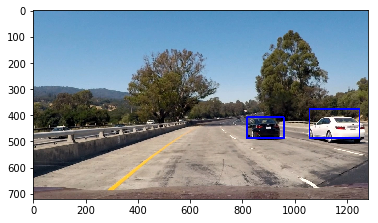

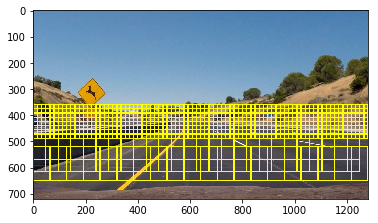

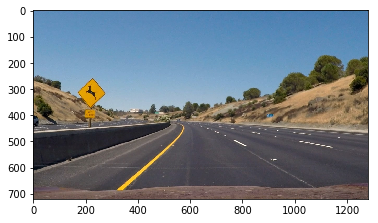

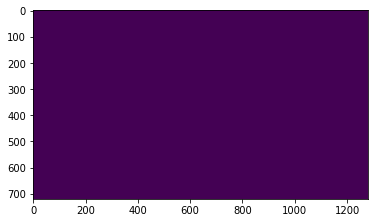

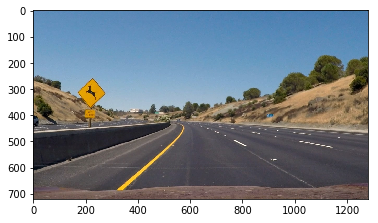

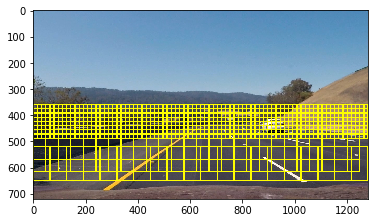

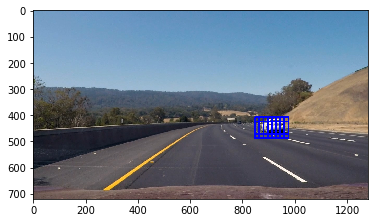

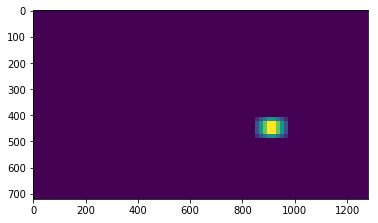

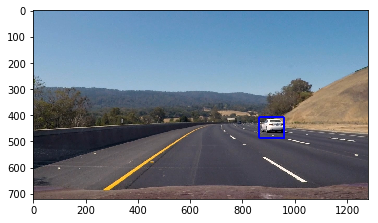

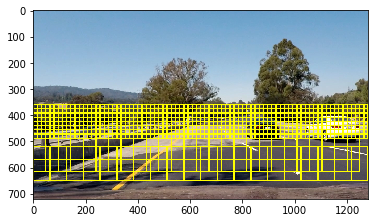

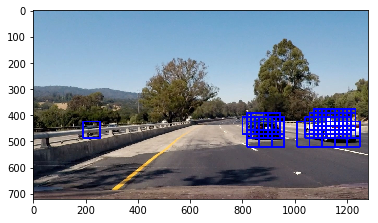

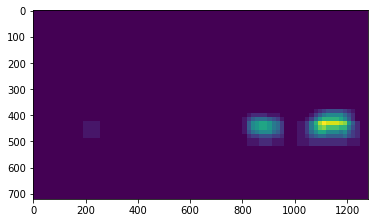

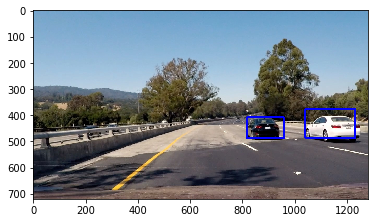

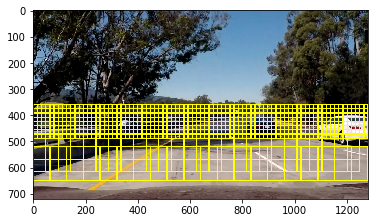

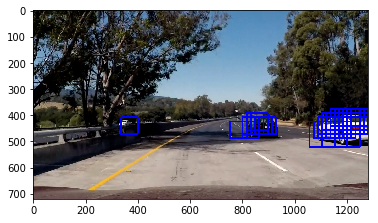

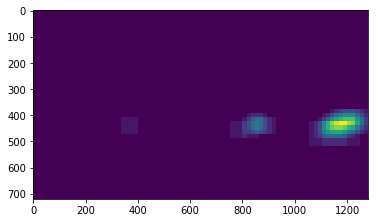

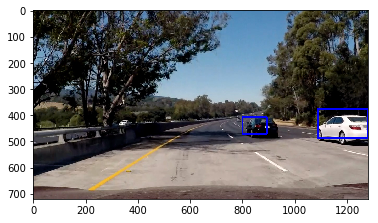

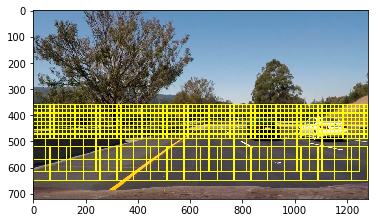

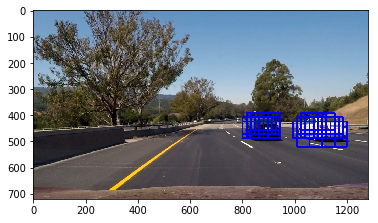

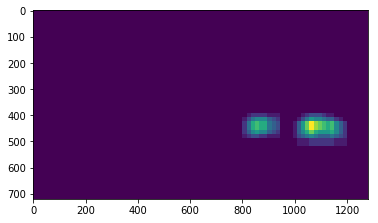

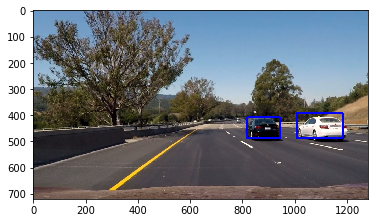

In [8]:
imagelist = ['test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']
for imgName in imagelist:
    image = cv2.cvtColor(cv2.imread(imgName), cv2.COLOR_BGR2RGB)
    output_img = ProcessImage(image, True)
    plt.imshow(output_img)
    plt.show()

In [9]:
output = 'test_video_output.mp4'
clip1 = VideoFileClip('test_video.mp4')
white_clip = clip1.fl_image(ProcessImage) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video test_video_output_1.mp4
[MoviePy] Writing video test_video_output_1.mp4


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 38/39 [01:27<00:02,  2.21s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output_1.mp4 

Wall time: 1min 29s


In [10]:
output = 'project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(ProcessImage) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video project_video_output-1.mp4
[MoviePy] Writing video project_video_output-1.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [47:45<00:02,  2.85s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output-1.mp4 

Wall time: 47min 46s
